In [72]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib

import rasterio
import shapefile
import cv2 as cv

import findatree.detect as detect

plt.style.use(r"C:\Repos\findatree\own.mplstyle")

### Define paths

In [50]:
dir_names=[]
dir_names.extend([r'C:\Repos\findatree\example-data\Orthophotos_2020'])
dir_names.extend([r'C:\Repos\findatree\example-data\Crown_delineation_2020'])

file_names=[]
file_names.extend(['Tnr_13758_2020_Ortho.tif'])
file_names.extend(['Tnr_13758_Kr.dbf'])

paths=[os.path.join(dir_names[i],file_name) for i, file_name in enumerate(file_names)]

### Load Ortho
Contains 6 bands but last band contains only zero values. \
Bands correspond to: 
1. blue (B): 450 nm ± 16 nm
2. gren (G): 560 nm ± 16 nm
3. red (R): 650 nm ± 16 nm
4. red edge (RE): 730 nm ± 16 nm
5. near infra-red (NIR): 840 nm ± 26 nm

In [51]:
with rasterio.open(paths[0]) as ds:
    print()
    print(f"Name: {ds.name}")
    print(f"Width: {ds.width}")
    print(f"Height: {ds.height}")

    print(f"No. of rasters: {ds.count}")
    for i, dtype in zip(ds.indexes, ds.dtypes):
        print(f"  Index: {i}, dtype: {dtype}")

    print(f"Coordinate reference system CRS: {ds.crs}")
    print(f"Geo bounds: {ds.bounds}")
    print(f"Resolution: {max(ds.transform[0], -ds.transform[4]):.3f} m")
    transform = ds.transform


Name: C:/Repos/findatree/example-data/Orthophotos_2020/Tnr_13758_2020_Ortho.tif
Width: 7927
Height: 4146
No. of rasters: 6
  Index: 1, dtype: uint16
  Index: 2, dtype: uint16
  Index: 3, dtype: uint16
  Index: 4, dtype: uint16
  Index: 5, dtype: uint16
  Index: 6, dtype: uint16
Coordinate reference system CRS: EPSG:25832
Geo bounds: BoundingBox(left=572032.487578263, bottom=5484378.806516255, right=572301.0326549745, top=5484519.261655406)
Resolution: 0.034 m


In [223]:
ds = rasterio.open(paths[0])
bs = np.zeros((ds.height, ds.width, ds.count - 1))

for i, idx in enumerate(range(1,ds.count)):
    bs[:, :, i] = ds.read(idx)

# Set boarder to zero
bs[bs == 2**16 -1] = 0

# Normalize to 1
bs = bs / 2**16

In [224]:
# bs_idx = 4
image = bs[:,:,4]
# image = np.mean(bs[:,:,[1,2,4]], axis=2)

# image_min = np.min(bs, axis=2)
# image_max = np.max(bs, axis=2)

# image = (image_min + image_max) / 2

# Convert to 8bit image
image = (image * 2**8).astype(np.uint8)

# Get min, max values
img_min = np.min(image.flatten())
img_max = np.max(image.flatten())

print(f"Min. value: {img_min:n}")
print(f"Max. value: {img_max:n}")

Min. value: 0
Max. value: 225


### Load shapefiles

In [64]:
sf = shapefile.Reader(paths[1])

polys = []
for i, shp in enumerate(sf.shapes()):
    poly = shp.points
    poly_px = [~transform * p for p in poly]
    poly_px = np.array([[p[0], p[1]] for p in poly_px])
    polys.append(poly_px)

In [228]:
# Gaussian blur
thresh = cv.GaussianBlur(image, (21,21), 15)

# Ostsu gloabl thresholding
ret, thresh = cv.threshold(thresh,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)

# Noise removal
kernel = np.ones((3,3),np.uint8)
thresh = cv.morphologyEx(thresh,cv.MORPH_OPEN,kernel, iterations = 10)

# Sure background area
# thresh = cv.dilate(thresh,kernel,iterations=3)

### Plotting

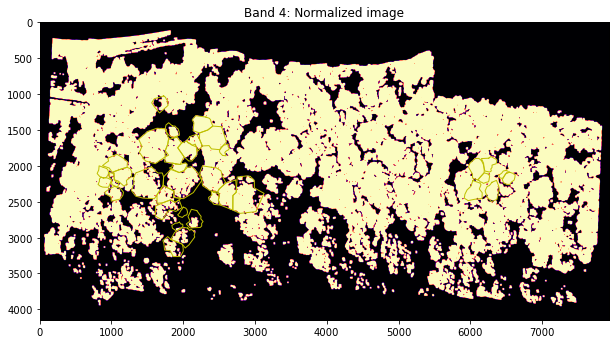

In [229]:
%matplotlib inline

f, ax = plt.subplots(figsize=(10,10))
mapp = ax.imshow(
    thresh,
    vmin=img_min,
    vmax=img_max,
    cmap='magma',
)

for poly in polys:
    ax.plot(poly[:, 0], poly[:, 1],'-', c='y', lw=1)

_ = ax.set_title(f"Band {bs_idx:n}: Normalized image")